In [1]:
import sys
import datasets
from dotenv import dotenv_values
from pathlib import Path
from scipy.special import softmax
import pandas as pd
import numpy as np

config = dotenv_values("./../../config/.env") # take environment variables from .env.
base_path = Path(config["BASE_PATH"])
sys.path.append(str(base_path/"code"))

In [2]:
df_l = datasets.concatenate_datasets([
    datasets.load_from_disk(base_path/"data/predictions/loss/active-learning-iteration-3"),
    datasets.load_from_disk(base_path/"data/predictions/loss/zero-shot-iteration-3"),
    datasets.load_from_disk(base_path/"data/predictions/loss/evaluate-iteration-3")]
).to_pandas()
df_l.drop(columns=["input_ids", "token_type_ids", "attention_mask"], inplace=True)

In [8]:
df_u = datasets.concatenate_datasets([
    datasets.load_from_disk(base_path/"data/predictions/unexpected/active-learning-iteration-3"),
    datasets.load_from_disk(base_path/"data/predictions/unexpected/zero-shot-iteration-3"),
    datasets.load_from_disk(base_path/"data/predictions/unexpected/evaluate-iteration-3")]
).to_pandas()
df_u.drop(columns=["input_ids", "token_type_ids", "attention_mask"], inplace=True)

In [10]:
df = df_l.merge(df_u[["report_id", "paragraph_nr", "logits_unexpected_AL_3"]], on=["report_id", "paragraph_nr"])
del df_l, df_u

In [15]:
df["p_loss"] = df["logits_loss_AL_3"].apply(lambda x: softmax(x)[0])
df["p_unexpected"] = df["logits_unexpected_AL_3"].apply(lambda x: softmax(x)[0])

In [16]:
df.to_pickle(base_path/"data/predictions/data.pkl")

In [2]:
df = pd.read_pickle(base_path/"data/predictions/data.pkl")

In [3]:
df_ul = df[(df.p_unexpected>0.5)& (df.p_loss>0.5)]
df_ul.shape

(5936, 9)

In [4]:
del df

<Axes: >

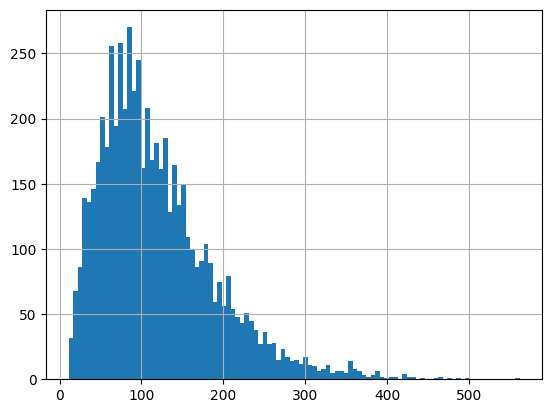

In [8]:
df_ul.n_words.hist(bins=100)

In [5]:
from nltk import sent_tokenize

In [8]:
df_ul["n_sentences"] = df_ul["text"].apply(lambda x: len(sent_tokenize(x)))

<Axes: >

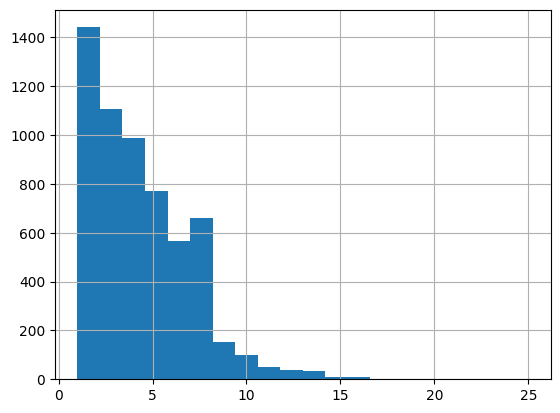

In [26]:
df_ul["n_sentences"].hist(bins=20)

In [9]:
df_ul["sentences"] = df_ul["text"].apply(lambda x: sent_tokenize(x))

In [6]:
def create_sliding_window_sentence_chunks(sentences, chunk_size):
    chunks = []
    chunk_id = []
    for i in range(len(sentences)-chunk_size+1):
        chunks.append(" ".join(sentences[i:i+chunk_size]))
        chunk_id.append(f"{chunk_size}_{i}")
    return {"chunk": chunks, "chunk_id": chunk_id}

def create_sentence_chunks(text, max_chunk_size=5):
    sentences = sent_tokenize(text)
    result = {"text": [], "chunk_id": []}
    for chunk_size in range(1, max_chunk_size+1):
        chunks = create_sliding_window_sentence_chunks(sentences, chunk_size)
        result["text"].extend(chunks["chunk"])
        result["chunk_id"].extend(chunks["chunk_id"])
    return result

In [7]:
df_ul["chunks"] = df_ul.text.apply(lambda x: create_sentence_chunks(x, max_chunk_size=5))

In [8]:
df_ul["chunk_nr"] = df_ul.chunks.apply(lambda x:  x["chunk_id"])
df_ul["chunk"] = df_ul.chunks.apply(lambda x:  x["text"])

In [11]:
df_ul = df_ul.drop(columns=["chunks", "text", "logits_loss_AL_3", "logits_unexpected_AL_3", "p_loss", "p_unexpected"])

In [12]:
df_chunks = df_ul.explode(["chunk", "chunk_nr"])

In [14]:
df_chunks.rename(columns={'chunk': 'text'}, inplace=True)

In [19]:
dataset = datasets.Dataset.from_pandas(df_chunks, preserve_index=False)

In [21]:
dataset.save_to_disk(base_path/"data"/"preprocessed"/"chunks")

Saving the dataset (0/1 shards):   0%|          | 0/78022 [00:00<?, ? examples/s]